In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
import matplotlib

from stratx.partdep import *
from rfpimp import plot_importances

In [153]:
def variation_importances(X: pd.DataFrame,
                          y: pd.Series) -> pd.DataFrame:
    """
    Compute model-free feature importances of dataset X,y using partial
    derivatives computed by the the StratPD algorithm.[1]  The feature
    importance of x is the ratio of the variation of x to the total
    variation explained by all p variables of X. By "variation of x,"
    we mean the "average absolute value of the partial derivative of y
    with respect to variable x", not the variance.  Normalizing the
    importances by the total variation implies they sum to 1.0 and
    describe the fraction of the total variation explained by each
    variable.  In other words, while other importance measures provide
    only relative importance among the variables, this method
    indicates how much each variable "explains" of the target y.

    For example, imagine data generated by y = x1 + 3*x2 + 5*x3 + 10
    for x1,x2,x3 from U(0,1), the uniform distribution in range [0,1).
    StratPD estimates the partial derivatives along each variable and
    then this function averages the abs of the partial derivative
    curve to approximate the linear model coefficients 1, 3, and 5
    that generated the data.  The normalized values are [1/9, 3/9, 5/9],
    where 9 is the total average variation 1+3+5.

    StratPD is a stratification method that first partitions an
    observed data set into groups of observations that are similar,
    except in the variable of interest, through the use of a decision
    tree. Any fluctuations of the y target variable within a group is
    likely due to the variable of interest.

    Since 0.2

    [1] https://arxiv.org/abs/1907.06698

    :param X: An nxp matrix of explanatory variables, one record per row
              of 2D matrix, for n records and p variables; this has to be
              a dataframe for now
    :param y: Target variable that is some function of X's variables
    :return: a dataframe with Feature, Importance, and Variation columns
             where Importance is the Variation column divided by total
             variation, np.sum(Variation)
    """
    if not isinstance(X, pd.DataFrame):
        raise ValueError("Can only operate on dataframes at the moment")

    p = X.shape[1]
    variations = np.zeros(shape=(p,))
    stddevs = np.zeros(shape=(p,))
    total_dy_mass = 0.0
    for j, colname in enumerate(X.columns):
        # Ask stratx package for the partial derivative of y with respect to X[colname]
        leaf_xranges, leaf_slopes, dx, dydx, pdpx, pdpy, ignored = \
            partial_dependence(X=X, y=y, colname=colname)
#         print(f"Ignored for {colname} = {ignored}")
        # record average abs of derivative divided by stddev to get z-score
        stddevs[j] = np.std(np.abs(dydx))
        variations[j] = np.mean(np.abs(dydx)) 
        total_dy_mass += variations[j]

    normalized_variations = variations / total_dy_mass
    
    I = pd.DataFrame(data={'Feature':X.columns,
                           'Importance': normalized_variations,
                           'Variation':variations,
                           '2sigma':stddevs})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)

    return I

In [167]:
def synthetic_poly_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*5 # get p random coefficients
#     coeff = np.array([1,3,5])
    # coeff = np.array([5,10])
    coeff = np.array([1,1,1,1,1,1])
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1) # shift x_i to right 2
#    df['x3'] = df['x1']+np.random.random_sample(size=n) # copy x1 + noise
    # multiply coefficients x each column (var) and sum along columns
    yintercept = 10
    df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 ) + yintercept
    #TODO add noise
    terms = [f"{coeff[i]:.1f}x_{i+1}" for i in range(p)] + [f"{yintercept:.0f}"]
    eqn = "y = " + ' + '.join(terms)
    return df, coeff, eqn

In [170]:
p=6
df, coeff, eqn = synthetic_poly_data(10000,p)
print(eqn)
X = df.drop('y', axis=1)
y = df['y']

I = variation_importances(X, y)
I

y = 1.0x_1 + 1.0x_2 + 1.0x_3 + 1.0x_4 + 1.0x_5 + 1.0x_6 + 10


,Importance,Variation,2sigma
Feature,,,
x2,0.172005,0.824853,0.222861
x5,0.167692,0.804169,0.194706
x1,0.167492,0.803211,0.219493
x6,0.166257,0.797290,0.234009
x3,0.163830,0.785650,0.249959
x4,0.162723,0.780341,0.232136


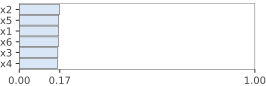

In [171]:
plot_importances(I, imp_range=(0,1.0))